In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Microbes Predict and Visualize Importance

# Data preparation

In [2]:
data0 = pd.read_csv("../input/microbes-dataset/microbes.csv")
data0

,Unnamed: 0,Solidity,Eccentricity,EquivDiameter,Extrema,FilledArea,Extent,Orientation,EulerNumber,BoundingBox1,...,ConvexHull4,MajorAxisLength,MinorAxisLength,Perimeter,ConvexArea,Centroid1,Centroid2,Area,raddi,microorganisms
0,0,10.70,15.8,5.43,3.75,0.7850,8.14,2.15,22.3,2.97,...,2.97,1.340,1.610,0.683,0.1950,3.63,12.10,1.310,7.99,Spirogyra
1,1,5.60,18.3,4.14,6.16,0.3640,3.51,18.60,22.5,5.41,...,5.47,1.520,1.520,1.010,0.2150,6.01,20.60,0.765,7.99,Spirogyra
2,2,8.32,19.8,4.63,6.66,0.4150,5.85,21.00,22.4,5.96,...,5.96,1.630,1.380,1.110,0.1820,6.55,11.50,0.953,7.99,Spirogyra
3,3,10.10,17.9,7.29,11.10,1.4700,6.30,9.94,21.9,8.81,...,8.88,2.040,2.120,0.715,0.3710,10.30,12.00,2.340,7.99,Spirogyra
4,4,6.27,20.2,20.10,10.70,14.7000,3.97,2.58,11.9,10.20,...,10.20,7.780,6.210,6.800,4.4400,14.00,9.55,17.600,7.99,Spirogyra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30522,30522,3.01,22.6,4.90,20.00,0.4340,1.40,19.90,22.1,18.10,...,18.60,4.350,1.350,1.710,0.5490,19.10,13.20,1.070,7.15,Ulothrix
30523,30523,5.19,22.6,2.07,19.40,0.0788,1.67,5.09,22.8,19.20,...,20.00,1.460,0.411,0.458,0.0597,19.80,17.20,0.197,7.15,Ulothrix
30524,30524,9.21,22.7,2.07,21.00,0.0790,5.81,12.70,22.8,20.10,...,20.10,1.060,0.257,0.319,0.0341,20.70,11.60,0.198,7.15,Ulothrix
30525,30525,8.21,22.6,1.87,20.50,0.0641,5.96,11.30,22.8,20.20,...,20.20,1.010,0.285,0.350,0.0314,20.80,20.40,0.162,7.15,Ulothrix


In [3]:
MName=data0['microorganisms'].unique().tolist()
print(len(MName))
MN=list(range(len(MName)))
normal_mapping=dict(zip(MName,MN)) 
reverse_mapping=dict(zip(MN,MName))        
data0['microorganisms']=data0['microorganisms'].map(normal_mapping)
print(normal_mapping)


10
{'Spirogyra': 0, 'Volvox': 1, 'Pithophora': 2, 'Yeast': 3, 'Raizopus': 4, 'Penicillum': 5, 'Aspergillus sp': 6, 'Protozoa': 7, 'Diatom': 8, 'Ulothrix': 9}


In [4]:
print(data0.columns.tolist())

['Unnamed: 0', 'Solidity', 'Eccentricity', 'EquivDiameter', 'Extrema', 'FilledArea', 'Extent', 'Orientation', 'EulerNumber', 'BoundingBox1', 'BoundingBox2', 'BoundingBox3', 'BoundingBox4', 'ConvexHull1', 'ConvexHull2', 'ConvexHull3', 'ConvexHull4', 'MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'ConvexArea', 'Centroid1', 'Centroid2', 'Area', 'raddi', 'microorganisms']


In [5]:
data0=data0.drop('Unnamed: 0',axis=1)

In [6]:
display(data0['microorganisms'])

0        0
1        0
2        0
3        0
4        0
        ..
30522    9
30523    9
30524    9
30525    9
30526    9
Name: microorganisms, Length: 30527, dtype: int64

In [7]:
dummies =  pd.get_dummies(data0['microorganisms'])
dummies.columns=MName
display(dummies)

,Spirogyra,Volvox,Pithophora,Yeast,Raizopus,Penicillum,Aspergillus sp,Protozoa,Diatom,Ulothrix
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
30522,0,0,0,0,0,0,0,0,0,1
30523,0,0,0,0,0,0,0,0,0,1
30524,0,0,0,0,0,0,0,0,0,1
30525,0,0,0,0,0,0,0,0,0,1


In [8]:
data0=pd.concat([data0,dummies],axis=1)
data0=data0.drop('microorganisms',axis=1)
display(data0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30527 entries, 0 to 30526
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Solidity         30527 non-null  float64
 1   Eccentricity     30527 non-null  float64
 2   EquivDiameter    30527 non-null  float64
 3   Extrema          30527 non-null  float64
 4   FilledArea       30527 non-null  float64
 5   Extent           30527 non-null  float64
 6   Orientation      30527 non-null  float64
 7   EulerNumber      30527 non-null  float64
 8   BoundingBox1     30527 non-null  float64
 9   BoundingBox2     30527 non-null  float64
 10  BoundingBox3     30527 non-null  float64
 11  BoundingBox4     30527 non-null  float64
 12  ConvexHull1      30527 non-null  float64
 13  ConvexHull2      30527 non-null  float64
 14  ConvexHull3      30527 non-null  float64
 15  ConvexHull4      30527 non-null  float64
 16  MajorAxisLength  30527 non-null  float64
 17  MinorAxisLen

None

from sklearn.preprocessing import LabelEncoder
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

data1=labelencoder(data0)
data1=data1.reset_index(drop=True)

# Target setting

In [9]:
target=MName
dataY=data0[target]
dataX=data0.drop(target,axis=1)

In [10]:
print(dataY[0:5].T)
print()
print(dataX[0:5].T)

                0  1  2  3  4
Spirogyra       1  1  1  1  1
Volvox          0  0  0  0  0
Pithophora      0  0  0  0  0
Yeast           0  0  0  0  0
Raizopus        0  0  0  0  0
Penicillum      0  0  0  0  0
Aspergillus sp  0  0  0  0  0
Protozoa        0  0  0  0  0
Diatom          0  0  0  0  0
Ulothrix        0  0  0  0  0

                      0       1       2       3      4
Solidity         10.700   5.600   8.320  10.100   6.27
Eccentricity     15.800  18.300  19.800  17.900  20.20
EquivDiameter     5.430   4.140   4.630   7.290  20.10
Extrema           3.750   6.160   6.660  11.100  10.70
FilledArea        0.785   0.364   0.415   1.470  14.70
Extent            8.140   3.510   5.850   6.300   3.97
Orientation       2.150  18.600  21.000   9.940   2.58
EulerNumber      22.300  22.500  22.400  21.900  11.90
BoundingBox1      2.970   5.410   5.960   8.810  10.20
BoundingBox2     10.900  19.200  10.200  10.700   1.22
BoundingBox3      1.750   1.770   1.510   3.340   8.40
BoundingB

In [11]:
n=len(dataX)
N=list(range(n))
random.seed(2021)
random.shuffle(N)

In [12]:
trainX=dataX.loc[N[0:(n//4)*3]]
trainY=dataY.loc[N[0:(n//4)*3]]
testX=dataX.loc[N[(n//4)*3:]]
testY=dataY.loc[N[(n//4)*3:]]

In [13]:
df_columns = list(dataX.columns)
print(df_columns)

['Solidity', 'Eccentricity', 'EquivDiameter', 'Extrema', 'FilledArea', 'Extent', 'Orientation', 'EulerNumber', 'BoundingBox1', 'BoundingBox2', 'BoundingBox3', 'BoundingBox4', 'ConvexHull1', 'ConvexHull2', 'ConvexHull3', 'ConvexHull4', 'MajorAxisLength', 'MinorAxisLength', 'Perimeter', 'ConvexArea', 'Centroid1', 'Centroid2', 'Area', 'raddi']


In [14]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [15]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [16]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [17]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 138.87it/s]


createcreate_numeric_feature  0.006[s]


100%|██████████| 1/1 [00:00<00:00, 325.75it/s]

createcreate_numeric_feature  0.001[s]


# Model

In [18]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [19]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [20]:
y = trainY
print(y.shape)
print(type(y))

(22893, 10)
<class 'pandas.core.frame.DataFrame'>


In [21]:
ydf=pd.DataFrame(y)
ydf

,Spirogyra,Volvox,Pithophora,Yeast,Raizopus,Penicillum,Aspergillus sp,Protozoa,Diatom,Ulothrix
4717,0,1,0,0,0,0,0,0,0,0
28380,0,0,0,0,0,0,0,0,0,1
17548,0,0,0,0,0,0,0,1,0,0
28762,0,0,0,0,0,0,0,0,0,1
28580,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
27245,0,0,0,0,0,0,0,0,0,1
12284,0,0,0,0,1,0,0,0,0,0
26466,0,0,0,0,0,0,0,0,0,1
12225,0,0,0,0,1,0,0,0,0,0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0609638
[1000]	valid_0's rmse: 0.0577356
[1500]	valid_0's rmse: 0.0564432
[2000]	valid_0's rmse: 0.0558882
[2500]	valid_0's rmse: 0.0556554
[3000]	valid_0's rmse: 0.0555032
[3500]	valid_0's rmse: 0.0554317
[4000]	valid_0's rmse: 0.0553888
fit fold=0  13.416[s]
Fold 0 RMSLE: 0.0554



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0524712
[1000]	valid_0's rmse: 0.0498459
[1500]	valid_0's rmse: 0.0483548
[2000]	valid_0's rmse: 0.0476713
[2500]	valid_0's rmse: 0.0473498
[3000]	valid_0's rmse: 0.0472262
[3500]	valid_0's rmse: 0.0471423
[4000]	valid_0's rmse: 0.0470865
[4500]	valid_0's rmse: 0.047041
[5000]	valid_0's rmse: 0.04701
[5500]	valid_0's rmse: 0.0469903
[6000]	valid_0's rmse: 0.0469738
[6500]	valid_0's rmse: 0.0469608
[7000]	valid_0's rmse: 0.0469489
fit fold=1  21.928[s]
Fold 1 RMSLE: 0.0469



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0710162
[1000]	valid_0's rmse: 0.0686147
[1500]	valid_0's rmse: 0.0671792
[2000]	valid_0's rmse: 0.0665596
[2500]	valid_0's rmse: 0.0662103
[3000]	valid_0's rmse: 0.0660431
[3500]	valid_0's rmse: 0.0659689
[4000]	valid_0's rmse: 0.0659208
[4500]	valid_0's rmse: 0.0658681
[5000]	valid_0's rmse: 0.0658383
[5500]	valid_0's rmse: 0.0658181
[6000]	valid_0's rmse: 0.0657977
[6500]	valid_0's rmse: 0.0657868
[7000]	valid_0's rmse: 0.065779
[7500]	valid_0's rmse: 0.0657698
[8000]	valid_0's rmse: 0.0657617
fit fold=2  24.400[s]
Fold 2 RMSLE: 0.0658



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0694295
[1000]	valid_0's rmse: 0.0664013
[1500]	valid_0's rmse: 0.0651915
[2000]	valid_0's rmse: 0.0646802
[2500]	valid_0's rmse: 0.0643374
[3000]	valid_0's rmse: 0.0642297
[3500]	valid_0's rmse: 0.064145
[4000]	valid_0's rmse: 0.0641055
[4500]	valid_0's rmse: 0.0640795
[5000]	valid_0's rmse: 0.0640545
[5500]	valid_0's rmse: 0.0640383
fit fold=3  17.172[s]
Fold 3 RMSLE: 0.0640



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0565566
[1000]	valid_0's rmse: 0.0536618
[1500]	valid_0's rmse: 0.0521568
[2000]	valid_0's rmse: 0.0516538
[2500]	valid_0's rmse: 0.0514009
[3000]	valid_0's rmse: 0.0513097
[3500]	valid_0's rmse: 0.0512623
[4000]	valid_0's rmse: 0.0512151
[4500]	valid_0's rmse: 0.0511908
[5000]	valid_0's rmse: 0.0511722
fit fold=4  17.026[s]
Fold 4 RMSLE: 0.0512

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0571


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0664567
[1000]	valid_0's rmse: 0.0410308
[1500]	valid_0's rmse: 0.0347083
[2000]	valid_0's rmse: 0.0325675
[2500]	valid_0's rmse: 0.031663
[3000]	valid_0's rmse: 0.0312316
[3500]	valid_0's rmse: 0.0310058
[4000]	valid_0's rmse: 0.0308614
[4500]	valid_0's rmse: 0.0307723
[5000]	valid_0's rmse: 0.0307152
[5500]	valid_0's rmse: 0.0306718
[6000]	valid_0's rmse: 0.0306379
[6500]	valid_0's rmse: 0.0306115
[7000]	valid_0's rmse: 0.0305964
fit fold=0  21.757[s]
Fold 0 RMSLE: 0.0306



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0722731
[1000]	valid_0's rmse: 0.0484233
[1500]	valid_0's rmse: 0.0431123
[2000]	valid_0's rmse: 0.0414875
[2500]	valid_0's rmse: 0.0408503
[3000]	valid_0's rmse: 0.0405691
[3500]	valid_0's rmse: 0.0404136
[4000]	valid_0's rmse: 0.040318
[4500]	valid_0's rmse: 0.0402493
[5000]	valid_0's rmse: 0.0401977
[5500]	valid_0's rmse: 0.0401694
[6000]	valid_0's rmse: 0.040142
[6500]	valid_0's rmse: 0.0401195
[7000]	valid_0's rmse: 0.040103
fit fold=1  21.168[s]
Fold 1 RMSLE: 0.0401



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.069912
[1000]	valid_0's rmse: 0.0437422
[1500]	valid_0's rmse: 0.0370191
[2000]	valid_0's rmse: 0.0347417
[2500]	valid_0's rmse: 0.0338833
[3000]	valid_0's rmse: 0.0334658
[3500]	valid_0's rmse: 0.033243
[4000]	valid_0's rmse: 0.0330989
[4500]	valid_0's rmse: 0.0330178
[5000]	valid_0's rmse: 0.0329506
[5500]	valid_0's rmse: 0.0329017
[6000]	valid_0's rmse: 0.0328647
[6500]	valid_0's rmse: 0.0328374
[7000]	valid_0's rmse: 0.0328177
[7500]	valid_0's rmse: 0.0328003
[8000]	valid_0's rmse: 0.0327842
[8500]	valid_0's rmse: 0.0327735
fit fold=2  25.768[s]
Fold 2 RMSLE: 0.0328



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0700618
[1000]	valid_0's rmse: 0.0421032
[1500]	valid_0's rmse: 0.0357858
[2000]	valid_0's rmse: 0.0338686
[2500]	valid_0's rmse: 0.0331073
[3000]	valid_0's rmse: 0.0327415
[3500]	valid_0's rmse: 0.0325731
[4000]	valid_0's rmse: 0.0324589
[4500]	valid_0's rmse: 0.0324002
[5000]	valid_0's rmse: 0.0323494
[5500]	valid_0's rmse: 0.0323167
[6000]	valid_0's rmse: 0.0322926
[6500]	valid_0's rmse: 0.0322759
[7000]	valid_0's rmse: 0.0322631
[7500]	valid_0's rmse: 0.0322495
[8000]	valid_0's rmse: 0.0322403
[8500]	valid_0's rmse: 0.032231
fit fold=3  26.466[s]
Fold 3 RMSLE: 0.0322



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0674812
[1000]	valid_0's rmse: 0.043863
[1500]	valid_0's rmse: 0.0380719
[2000]	valid_0's rmse: 0.0360291
[2500]	valid_0's rmse: 0.0352581
[3000]	valid_0's rmse: 0.0348969
[3500]	valid_0's rmse: 0.0347127
[4000]	valid_0's rmse: 0.034609
[4500]	valid_0's rmse: 0.0345418
[5000]	valid_0's rmse: 0.0344887
[5500]	valid_0's rmse: 0.0344519
[6000]	valid_0's rmse: 0.0344268
[6500]	valid_0's rmse: 0.0344012
[7000]	valid_0's rmse: 0.0343871
[7500]	valid_0's rmse: 0.0343752
[8000]	valid_0's rmse: 0.0343635
fit fold=4  24.374[s]
Fold 4 RMSLE: 0.0344

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0342


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.078441
[1000]	valid_0's rmse: 0.0651559
[1500]	valid_0's rmse: 0.0605106
[2000]	valid_0's rmse: 0.0587877
[2500]	valid_0's rmse: 0.0580563
[3000]	valid_0's rmse: 0.0577283
[3500]	valid_0's rmse: 0.0575698
[4000]	valid_0's rmse: 0.0574654
[4500]	valid_0's rmse: 0.0573961
[5000]	valid_0's rmse: 0.0573476
[5500]	valid_0's rmse: 0.0573138
[6000]	valid_0's rmse: 0.0572915
[6500]	valid_0's rmse: 0.0572764
[7000]	valid_0's rmse: 0.0572568
[7500]	valid_0's rmse: 0.0572429
[8000]	valid_0's rmse: 0.0572345
[8500]	valid_0's rmse: 0.0572281
[9000]	valid_0's rmse: 0.0572223
fit fold=0  26.999[s]
Fold 0 RMSLE: 0.0572



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0892113
[1000]	valid_0's rmse: 0.0764739
[1500]	valid_0's rmse: 0.0722161
[2000]	valid_0's rmse: 0.0704453
[2500]	valid_0's rmse: 0.0697081
[3000]	valid_0's rmse: 0.0694283
[3500]	valid_0's rmse: 0.0692483
[4000]	valid_0's rmse: 0.0691589
[4500]	valid_0's rmse: 0.0691014
[5000]	valid_0's rmse: 0.0690578
[5500]	valid_0's rmse: 0.0690292
[6000]	valid_0's rmse: 0.0690093
[6500]	valid_0's rmse: 0.0689952
[7000]	valid_0's rmse: 0.0689831
[7500]	valid_0's rmse: 0.0689722
fit fold=1  23.315[s]
Fold 1 RMSLE: 0.0690



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0909033
[1000]	valid_0's rmse: 0.0792985
[1500]	valid_0's rmse: 0.0753229
[2000]	valid_0's rmse: 0.073449
[2500]	valid_0's rmse: 0.0727673
[3000]	valid_0's rmse: 0.0724743
[3500]	valid_0's rmse: 0.072323
[4000]	valid_0's rmse: 0.0722239
[4500]	valid_0's rmse: 0.0721603
[5000]	valid_0's rmse: 0.0721271
fit fold=2  15.209[s]
Fold 2 RMSLE: 0.0721



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0887357
[1000]	valid_0's rmse: 0.07543
[1500]	valid_0's rmse: 0.0711117
[2000]	valid_0's rmse: 0.0694478
[2500]	valid_0's rmse: 0.0686434
[3000]	valid_0's rmse: 0.0683223
[3500]	valid_0's rmse: 0.0681717
[4000]	valid_0's rmse: 0.0680393
[4500]	valid_0's rmse: 0.06798
[5000]	valid_0's rmse: 0.0679328
[5500]	valid_0's rmse: 0.0679057
[6000]	valid_0's rmse: 0.0678813
[6500]	valid_0's rmse: 0.0678619
[7000]	valid_0's rmse: 0.0678511
fit fold=3  22.447[s]
Fold 3 RMSLE: 0.0678



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0843846
[1000]	valid_0's rmse: 0.0709032
[1500]	valid_0's rmse: 0.0654851
[2000]	valid_0's rmse: 0.0633132
[2500]	valid_0's rmse: 0.0623905
[3000]	valid_0's rmse: 0.0620002
[3500]	valid_0's rmse: 0.0617807
[4000]	valid_0's rmse: 0.0616699
[4500]	valid_0's rmse: 0.0616009
[5000]	valid_0's rmse: 0.0615517
[5500]	valid_0's rmse: 0.0615084
[6000]	valid_0's rmse: 0.0614844
[6500]	valid_0's rmse: 0.0614687
[7000]	valid_0's rmse: 0.061449
fit fold=4  21.146[s]
Fold 4 RMSLE: 0.0614

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0657


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0694965
[1000]	valid_0's rmse: 0.0508367
[1500]	valid_0's rmse: 0.0448114
[2000]	valid_0's rmse: 0.0427142
[2500]	valid_0's rmse: 0.0418712
[3000]	valid_0's rmse: 0.0414633
[3500]	valid_0's rmse: 0.0412425
[4000]	valid_0's rmse: 0.041108
[4500]	valid_0's rmse: 0.041021
[5000]	valid_0's rmse: 0.0409596
[5500]	valid_0's rmse: 0.0409109
[6000]	valid_0's rmse: 0.0408737
[6500]	valid_0's rmse: 0.0408479
[7000]	valid_0's rmse: 0.0408333
[7500]	valid_0's rmse: 0.0408213
[8000]	valid_0's rmse: 0.0408036
fit fold=0  23.729[s]
Fold 0 RMSLE: 0.0408



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.067779
[1000]	valid_0's rmse: 0.0470259
[1500]	valid_0's rmse: 0.0414438
[2000]	valid_0's rmse: 0.0398281
[2500]	valid_0's rmse: 0.0392399
[3000]	valid_0's rmse: 0.0389704
[3500]	valid_0's rmse: 0.0388226
[4000]	valid_0's rmse: 0.0387436
[4500]	valid_0's rmse: 0.0386808
[5000]	valid_0's rmse: 0.0386453
[5500]	valid_0's rmse: 0.0386239
[6000]	valid_0's rmse: 0.0386095
[6500]	valid_0's rmse: 0.0385937
[7000]	valid_0's rmse: 0.0385849
fit fold=1  21.571[s]
Fold 1 RMSLE: 0.0386



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0708661
[1000]	valid_0's rmse: 0.0493572
[1500]	valid_0's rmse: 0.0430022
[2000]	valid_0's rmse: 0.0408477
[2500]	valid_0's rmse: 0.0400469
[3000]	valid_0's rmse: 0.0396253
[3500]	valid_0's rmse: 0.0394394
[4000]	valid_0's rmse: 0.0393176
[4500]	valid_0's rmse: 0.039235
[5000]	valid_0's rmse: 0.0391901
[5500]	valid_0's rmse: 0.0391516
[6000]	valid_0's rmse: 0.0391189
[6500]	valid_0's rmse: 0.0390943
[7000]	valid_0's rmse: 0.0390796
[7500]	valid_0's rmse: 0.0390668
[8000]	valid_0's rmse: 0.0390584
fit fold=2  24.301[s]
Fold 2 RMSLE: 0.0391



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0714015
[1000]	valid_0's rmse: 0.0470625
[1500]	valid_0's rmse: 0.0393735
[2000]	valid_0's rmse: 0.0367816
[2500]	valid_0's rmse: 0.0357834
[3000]	valid_0's rmse: 0.0353498
[3500]	valid_0's rmse: 0.0351192
[4000]	valid_0's rmse: 0.0349784
[4500]	valid_0's rmse: 0.0348843
[5000]	valid_0's rmse: 0.0348206
[5500]	valid_0's rmse: 0.034769
[6000]	valid_0's rmse: 0.0347323
[6500]	valid_0's rmse: 0.0347032
[7000]	valid_0's rmse: 0.0346791
[7500]	valid_0's rmse: 0.0346598
[8000]	valid_0's rmse: 0.0346422
[8500]	valid_0's rmse: 0.0346301
[9000]	valid_0's rmse: 0.0346215
fit fold=3  26.910[s]
Fold 3 RMSLE: 0.0346



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0680488
[1000]	valid_0's rmse: 0.0492021
[1500]	valid_0's rmse: 0.0441403
[2000]	valid_0's rmse: 0.0426707
[2500]	valid_0's rmse: 0.0421442
[3000]	valid_0's rmse: 0.0419128
[3500]	valid_0's rmse: 0.0417692
[4000]	valid_0's rmse: 0.0417014
[4500]	valid_0's rmse: 0.0416517
[5000]	valid_0's rmse: 0.0416086
[5500]	valid_0's rmse: 0.0415814
[6000]	valid_0's rmse: 0.041559
[6500]	valid_0's rmse: 0.0415456
[7000]	valid_0's rmse: 0.0415321
[7500]	valid_0's rmse: 0.0415246
[8000]	valid_0's rmse: 0.0415193
fit fold=4  23.197[s]
Fold 4 RMSLE: 0.0415

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0390


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.00727441
[1000]	valid_0's rmse: 0.00491189
[1500]	valid_0's rmse: 0.00431054
[2000]	valid_0's rmse: 0.00406677
[2500]	valid_0's rmse: 0.00393055
fit fold=0  7.762[s]
Fold 0 RMSLE: 0.0039



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.00949856
[1000]	valid_0's rmse: 0.00645902
[1500]	valid_0's rmse: 0.00567964
[2000]	valid_0's rmse: 0.00541646
[2500]	valid_0's rmse: 0.00527764
fit fold=1  7.735[s]
Fold 1 RMSLE: 0.0052



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.00869679
[1000]	valid_0's rmse: 0.00621334
[1500]	valid_0's rmse: 0.0054886
[2000]	valid_0's rmse: 0.00515322
[2500]	valid_0's rmse: 0.00499192
fit fold=2  7.236[s]
Fold 2 RMSLE: 0.0050



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.00832648
[1000]	valid_0's rmse: 0.00651016
[1500]	valid_0's rmse: 0.00620834
[2000]	valid_0's rmse: 0.00610618
fit fold=3  5.829[s]
Fold 3 RMSLE: 0.0061



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0222615
[1000]	valid_0's rmse: 0.0215027
[1500]	valid_0's rmse: 0.0213946
[2000]	valid_0's rmse: 0.0213458
fit fold=4  7.462[s]
Fold 4 RMSLE: 0.0213

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0106


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.024652
[1000]	valid_0's rmse: 0.0193985
[1500]	valid_0's rmse: 0.0181
[2000]	valid_0's rmse: 0.017646
[2500]	valid_0's rmse: 0.0174282
[3000]	valid_0's rmse: 0.0173128
[3500]	valid_0's rmse: 0.0172369
[4000]	valid_0's rmse: 0.0171892
fit fold=0  12.673[s]
Fold 0 RMSLE: 0.0172



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0336976
[1000]	valid_0's rmse: 0.0270646
[1500]	valid_0's rmse: 0.0256803
[2000]	valid_0's rmse: 0.0252436
[2500]	valid_0's rmse: 0.0250793
[3000]	valid_0's rmse: 0.0249858
[3500]	valid_0's rmse: 0.0249252
[4000]	valid_0's rmse: 0.0248819
[4500]	valid_0's rmse: 0.0248519
[5000]	valid_0's rmse: 0.0248231
[5500]	valid_0's rmse: 0.0248068
[6000]	valid_0's rmse: 0.0247903
fit fold=1  18.063[s]
Fold 1 RMSLE: 0.0248



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.023141
[1000]	valid_0's rmse: 0.0169221
[1500]	valid_0's rmse: 0.0155944
[2000]	valid_0's rmse: 0.0151267
[2500]	valid_0's rmse: 0.0149402
[3000]	valid_0's rmse: 0.0148368
[3500]	valid_0's rmse: 0.0147682
[4000]	valid_0's rmse: 0.0147243
[4500]	valid_0's rmse: 0.0146946
fit fold=2  13.666[s]
Fold 2 RMSLE: 0.0147



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.025828
[1000]	valid_0's rmse: 0.0169639
[1500]	valid_0's rmse: 0.0146026
[2000]	valid_0's rmse: 0.0138666
[2500]	valid_0's rmse: 0.0135475
[3000]	valid_0's rmse: 0.0133783
[3500]	valid_0's rmse: 0.0132776
[4000]	valid_0's rmse: 0.0132063
[4500]	valid_0's rmse: 0.0131526
[5000]	valid_0's rmse: 0.0131127
fit fold=3  15.047[s]
Fold 3 RMSLE: 0.0131



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0368121
[1000]	valid_0's rmse: 0.0309464
[1500]	valid_0's rmse: 0.0298957
[2000]	valid_0's rmse: 0.0296378
[2500]	valid_0's rmse: 0.0295013
fit fold=4  8.299[s]
Fold 4 RMSLE: 0.0295

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0208


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.115062
[1000]	valid_0's rmse: 0.0829632
[1500]	valid_0's rmse: 0.069975
[2000]	valid_0's rmse: 0.0639953
[2500]	valid_0's rmse: 0.0615629
[3000]	valid_0's rmse: 0.0605253
[3500]	valid_0's rmse: 0.0599822
[4000]	valid_0's rmse: 0.0597014
[4500]	valid_0's rmse: 0.0595402
[5000]	valid_0's rmse: 0.0594322
[5500]	valid_0's rmse: 0.0593641
[6000]	valid_0's rmse: 0.0593117
[6500]	valid_0's rmse: 0.059271
[7000]	valid_0's rmse: 0.0592388
[7500]	valid_0's rmse: 0.0592152
[8000]	valid_0's rmse: 0.0591987
[8500]	valid_0's rmse: 0.0591864
[9000]	valid_0's rmse: 0.0591727
[9500]	valid_0's rmse: 0.0591619
[10000]	valid_0's rmse: 0.0591522
fit fold=0  29.961[s]
Fold 0 RMSLE: 0.0592



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.123525
[1000]	valid_0's rmse: 0.0957345
[1500]	valid_0's rmse: 0.0847926
[2000]	valid_0's rmse: 0.0800441
[2500]	valid_0's rmse: 0.0779486
[3000]	valid_0's rmse: 0.0769473
[3500]	valid_0's rmse: 0.0765493
[4000]	valid_0's rmse: 0.0763447
[4500]	valid_0's rmse: 0.0762075
[5000]	valid_0's rmse: 0.0761208
[5500]	valid_0's rmse: 0.0760686
[6000]	valid_0's rmse: 0.0760335
[6500]	valid_0's rmse: 0.0760079
[7000]	valid_0's rmse: 0.0759847
[7500]	valid_0's rmse: 0.0759711
[8000]	valid_0's rmse: 0.0759562
fit fold=1  24.950[s]
Fold 1 RMSLE: 0.0760



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.118069
[1000]	valid_0's rmse: 0.0876961
[1500]	valid_0's rmse: 0.0763868
[2000]	valid_0's rmse: 0.0714582
[2500]	valid_0's rmse: 0.0695216
[3000]	valid_0's rmse: 0.0686238
[3500]	valid_0's rmse: 0.0681893
[4000]	valid_0's rmse: 0.0679524
[4500]	valid_0's rmse: 0.0678141
[5000]	valid_0's rmse: 0.0677079
[5500]	valid_0's rmse: 0.067642
[6000]	valid_0's rmse: 0.0675896
[6500]	valid_0's rmse: 0.0675572
[7000]	valid_0's rmse: 0.0675249
[7500]	valid_0's rmse: 0.0675061
[8000]	valid_0's rmse: 0.0674924
[8500]	valid_0's rmse: 0.0674787
[9000]	valid_0's rmse: 0.0674646
[9500]	valid_0's rmse: 0.0674543
[10000]	valid_0's rmse: 0.0674495
fit fold=2  29.972[s]
Fold 2 RMSLE: 0.0674



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.120111
[1000]	valid_0's rmse: 0.0936576
[1500]	valid_0's rmse: 0.0836886
[2000]	valid_0's rmse: 0.0797811
[2500]	valid_0's rmse: 0.0779581
[3000]	valid_0's rmse: 0.0771704
[3500]	valid_0's rmse: 0.0767878
[4000]	valid_0's rmse: 0.0766091
[4500]	valid_0's rmse: 0.0764837
[5000]	valid_0's rmse: 0.076414
[5500]	valid_0's rmse: 0.0763666
[6000]	valid_0's rmse: 0.076326
[6500]	valid_0's rmse: 0.0763041
[7000]	valid_0's rmse: 0.0762827
fit fold=3  22.506[s]
Fold 3 RMSLE: 0.0763



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.120144
[1000]	valid_0's rmse: 0.0950745
[1500]	valid_0's rmse: 0.08672
[2000]	valid_0's rmse: 0.0831796
[2500]	valid_0's rmse: 0.0818102
[3000]	valid_0's rmse: 0.0811565
[3500]	valid_0's rmse: 0.0808751
[4000]	valid_0's rmse: 0.0807125
[4500]	valid_0's rmse: 0.0806154
[5000]	valid_0's rmse: 0.0805705
[5500]	valid_0's rmse: 0.0805308
[6000]	valid_0's rmse: 0.0805046
[6500]	valid_0's rmse: 0.0804856
[7000]	valid_0's rmse: 0.0804675
[7500]	valid_0's rmse: 0.0804553
fit fold=4  24.147[s]
Fold 4 RMSLE: 0.0805

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0723


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0392232
[1000]	valid_0's rmse: 0.028632
[1500]	valid_0's rmse: 0.0258074
[2000]	valid_0's rmse: 0.024821
[2500]	valid_0's rmse: 0.0244146
[3000]	valid_0's rmse: 0.0242021
[3500]	valid_0's rmse: 0.0240772
[4000]	valid_0's rmse: 0.0240019
[4500]	valid_0's rmse: 0.0239493
[5000]	valid_0's rmse: 0.0239103
[5500]	valid_0's rmse: 0.0238827
[6000]	valid_0's rmse: 0.0238593
fit fold=0  19.212[s]
Fold 0 RMSLE: 0.0239



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0402601
[1000]	valid_0's rmse: 0.0273334
[1500]	valid_0's rmse: 0.023498
[2000]	valid_0's rmse: 0.0220975
[2500]	valid_0's rmse: 0.0215364
[3000]	valid_0's rmse: 0.0212553
[3500]	valid_0's rmse: 0.0210888
[4000]	valid_0's rmse: 0.0209826
[4500]	valid_0's rmse: 0.0209208
[5000]	valid_0's rmse: 0.0208683
[5500]	valid_0's rmse: 0.0208362
[6000]	valid_0's rmse: 0.0208051
[6500]	valid_0's rmse: 0.0207834
[7000]	valid_0's rmse: 0.020764
[7500]	valid_0's rmse: 0.0207473
fit fold=1  23.362[s]
Fold 1 RMSLE: 0.0207



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.039771
[1000]	valid_0's rmse: 0.03048
[1500]	valid_0's rmse: 0.0280081
[2000]	valid_0's rmse: 0.0271038
[2500]	valid_0's rmse: 0.0267175
[3000]	valid_0's rmse: 0.026506
[3500]	valid_0's rmse: 0.026385
[4000]	valid_0's rmse: 0.0263033
[4500]	valid_0's rmse: 0.0262497
[5000]	valid_0's rmse: 0.0262088
[5500]	valid_0's rmse: 0.0261812
[6000]	valid_0's rmse: 0.0261598
[6500]	valid_0's rmse: 0.0261462
[7000]	valid_0's rmse: 0.0261342
[7500]	valid_0's rmse: 0.0261212
fit fold=2  25.957[s]
Fold 2 RMSLE: 0.0261



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0379319
[1000]	valid_0's rmse: 0.0268024
[1500]	valid_0's rmse: 0.0235927
[2000]	valid_0's rmse: 0.0224258
[2500]	valid_0's rmse: 0.0219283
[3000]	valid_0's rmse: 0.021668
[3500]	valid_0's rmse: 0.0215314
[4000]	valid_0's rmse: 0.0214439
[4500]	valid_0's rmse: 0.0213742
[5000]	valid_0's rmse: 0.0213245
[5500]	valid_0's rmse: 0.021293
[6000]	valid_0's rmse: 0.0212646
fit fold=3  18.591[s]
Fold 3 RMSLE: 0.0212



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0377597
[1000]	valid_0's rmse: 0.0273013
[1500]	valid_0's rmse: 0.0239856
[2000]	valid_0's rmse: 0.0227421
[2500]	valid_0's rmse: 0.0221621
[3000]	valid_0's rmse: 0.0218925
[3500]	valid_0's rmse: 0.0217333
[4000]	valid_0's rmse: 0.0216339
[4500]	valid_0's rmse: 0.0215541
[5000]	valid_0's rmse: 0.0215064
[5500]	valid_0's rmse: 0.0214694
[6000]	valid_0's rmse: 0.0214423
[6500]	valid_0's rmse: 0.0214177
[7000]	valid_0's rmse: 0.0214027
fit fold=4  21.189[s]
Fold 4 RMSLE: 0.0214

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0228


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0573218
[1000]	valid_0's rmse: 0.0366572
[1500]	valid_0's rmse: 0.0309607
[2000]	valid_0's rmse: 0.0291515
[2500]	valid_0's rmse: 0.0284647
[3000]	valid_0's rmse: 0.0281415
[3500]	valid_0's rmse: 0.0279513
[4000]	valid_0's rmse: 0.0278478
[4500]	valid_0's rmse: 0.0277771
[5000]	valid_0's rmse: 0.027726
[5500]	valid_0's rmse: 0.0276954
[6000]	valid_0's rmse: 0.0276721
[6500]	valid_0's rmse: 0.027646
[7000]	valid_0's rmse: 0.027631
[7500]	valid_0's rmse: 0.0276179
fit fold=0  23.163[s]
Fold 0 RMSLE: 0.0276



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0527567
[1000]	valid_0's rmse: 0.0341603
[1500]	valid_0's rmse: 0.0284711
[2000]	valid_0's rmse: 0.0265924
[2500]	valid_0's rmse: 0.0258964
[3000]	valid_0's rmse: 0.0255866
[3500]	valid_0's rmse: 0.0254072
[4000]	valid_0's rmse: 0.0253041
[4500]	valid_0's rmse: 0.0252439
[5000]	valid_0's rmse: 0.025196
[5500]	valid_0's rmse: 0.025162
[6000]	valid_0's rmse: 0.0251341
[6500]	valid_0's rmse: 0.025114
[7000]	valid_0's rmse: 0.0250979
[7500]	valid_0's rmse: 0.0250858
fit fold=1  22.352[s]
Fold 1 RMSLE: 0.0251



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.064336
[1000]	valid_0's rmse: 0.0453972
[1500]	valid_0's rmse: 0.0402985
[2000]	valid_0's rmse: 0.0385172
[2500]	valid_0's rmse: 0.0377917
[3000]	valid_0's rmse: 0.0374745
[3500]	valid_0's rmse: 0.0372894
[4000]	valid_0's rmse: 0.0371633
[4500]	valid_0's rmse: 0.0370865
[5000]	valid_0's rmse: 0.03703
[5500]	valid_0's rmse: 0.0369923
[6000]	valid_0's rmse: 0.036962
[6500]	valid_0's rmse: 0.0369364
[7000]	valid_0's rmse: 0.0369138
[7500]	valid_0's rmse: 0.0368954
fit fold=2  24.264[s]
Fold 2 RMSLE: 0.0369



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0595758
[1000]	valid_0's rmse: 0.0415219
[1500]	valid_0's rmse: 0.0364658
[2000]	valid_0's rmse: 0.0350421
[2500]	valid_0's rmse: 0.0344624
[3000]	valid_0's rmse: 0.0341818
[3500]	valid_0's rmse: 0.0340599
[4000]	valid_0's rmse: 0.0339863
[4500]	valid_0's rmse: 0.0339335
[5000]	valid_0's rmse: 0.0339007
[5500]	valid_0's rmse: 0.0338738
fit fold=3  17.714[s]
Fold 3 RMSLE: 0.0339



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0571309
[1000]	valid_0's rmse: 0.0387315
[1500]	valid_0's rmse: 0.0339092
[2000]	valid_0's rmse: 0.0323571
[2500]	valid_0's rmse: 0.031769
[3000]	valid_0's rmse: 0.0314724
[3500]	valid_0's rmse: 0.031308
[4000]	valid_0's rmse: 0.0312065
[4500]	valid_0's rmse: 0.0311408
[5000]	valid_0's rmse: 0.0310926
[5500]	valid_0's rmse: 0.0310599
[6000]	valid_0's rmse: 0.0310323
[6500]	valid_0's rmse: 0.0310112
[7000]	valid_0's rmse: 0.030994
[7500]	valid_0's rmse: 0.0309825
[8000]	valid_0's rmse: 0.0309703
fit fold=4  23.774[s]
Fold 4 RMSLE: 0.0310

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.135657
[1000]	valid_0's rmse: 0.09626
[1500]	valid_0's rmse: 0.0817126
[2000]	valid_0's rmse: 0.0761184
[2500]	valid_0's rmse: 0.0737332
[3000]	valid_0's rmse: 0.0725827
[3500]	valid_0's rmse: 0.0720122
[4000]	valid_0's rmse: 0.0717067
[4500]	valid_0's rmse: 0.0715458
[5000]	valid_0's rmse: 0.0714371
[5500]	valid_0's rmse: 0.0713539
[6000]	valid_0's rmse: 0.0713115
[6500]	valid_0's rmse: 0.0712726
[7000]	valid_0's rmse: 0.0712451
[7500]	valid_0's rmse: 0.0712206
[8000]	valid_0's rmse: 0.0712008
[8500]	valid_0's rmse: 0.0711882
[9000]	valid_0's rmse: 0.0711753
[9500]	valid_0's rmse: 0.0711637
[10000]	valid_0's rmse: 0.0711545
fit fold=0  29.793[s]
Fold 0 RMSLE: 0.0712



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.133881
[1000]	valid_0's rmse: 0.0979525
[1500]	valid_0's rmse: 0.0866018
[2000]	valid_0's rmse: 0.0824913
[2500]	valid_0's rmse: 0.0807016
[3000]	valid_0's rmse: 0.0799241
[3500]	valid_0's rmse: 0.0795134
[4000]	valid_0's rmse: 0.0793133
[4500]	valid_0's rmse: 0.0791941
[5000]	valid_0's rmse: 0.0791163
[5500]	valid_0's rmse: 0.0790507
[6000]	valid_0's rmse: 0.0790084
[6500]	valid_0's rmse: 0.0789839
[7000]	valid_0's rmse: 0.0789623
[7500]	valid_0's rmse: 0.078947
[8000]	valid_0's rmse: 0.0789363
fit fold=1  25.276[s]
Fold 1 RMSLE: 0.0789



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.141576
[1000]	valid_0's rmse: 0.103342
[1500]	valid_0's rmse: 0.090688
[2000]	valid_0's rmse: 0.0858999
[2500]	valid_0's rmse: 0.0840091
[3000]	valid_0's rmse: 0.0832147
[3500]	valid_0's rmse: 0.0828001
[4000]	valid_0's rmse: 0.0826047
[4500]	valid_0's rmse: 0.0824746
[5000]	valid_0's rmse: 0.0823945
[5500]	valid_0's rmse: 0.0823302
[6000]	valid_0's rmse: 0.0822925
[6500]	valid_0's rmse: 0.082266
[7000]	valid_0's rmse: 0.0822499
[7500]	valid_0's rmse: 0.0822353
[8000]	valid_0's rmse: 0.0822207
fit fold=2  27.049[s]
Fold 2 RMSLE: 0.0822



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.138136
[1000]	valid_0's rmse: 0.0989811
[1500]	valid_0's rmse: 0.0853837
[2000]	valid_0's rmse: 0.0804422
[2500]	valid_0's rmse: 0.0783934
[3000]	valid_0's rmse: 0.0773961
[3500]	valid_0's rmse: 0.0769444
[4000]	valid_0's rmse: 0.0767117
[4500]	valid_0's rmse: 0.0765574
[5000]	valid_0's rmse: 0.076452
[5500]	valid_0's rmse: 0.0763819
[6000]	valid_0's rmse: 0.0763485
[6500]	valid_0's rmse: 0.0763154
[7000]	valid_0's rmse: 0.0762862
[7500]	valid_0's rmse: 0.0762655
[8000]	valid_0's rmse: 0.0762461
[8500]	valid_0's rmse: 0.0762282
[9000]	valid_0's rmse: 0.0762155
[9500]	valid_0's rmse: 0.0762066
[10000]	valid_0's rmse: 0.0761983
fit fold=3  30.703[s]
Fold 3 RMSLE: 0.0762



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.14156
[1000]	valid_0's rmse: 0.105176
[1500]	valid_0's rmse: 0.0938139
[2000]	valid_0's rmse: 0.0892573
[2500]	valid_0's rmse: 0.0873742
[3000]	valid_0's rmse: 0.0865812
[3500]	valid_0's rmse: 0.0862172
[4000]	valid_0's rmse: 0.0859853
[4500]	valid_0's rmse: 0.085858
[5000]	valid_0's rmse: 0.085793
[5500]	valid_0's rmse: 0.0857536
[6000]	valid_0's rmse: 0.0857222
[6500]	valid_0's rmse: 0.0856984
[7000]	valid_0's rmse: 0.0856801
[7500]	valid_0's rmse: 0.085666
[8000]	valid_0's rmse: 0.085652
[8500]	valid_0's rmse: 0.085642
fit fold=4  27.296[s]
Fold 4 RMSLE: 0.0856

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0790


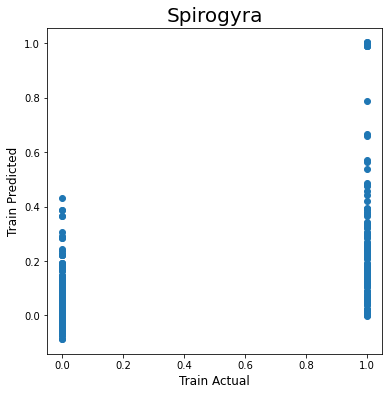

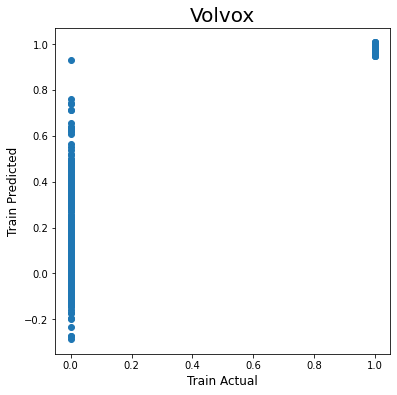

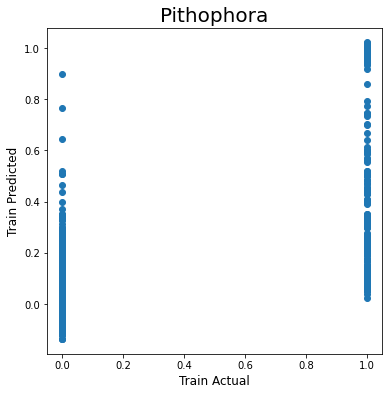

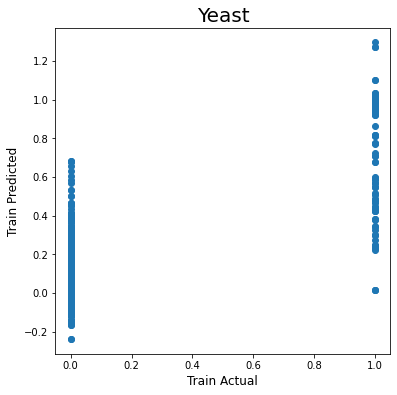

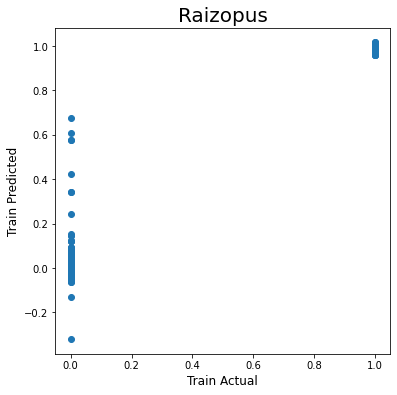

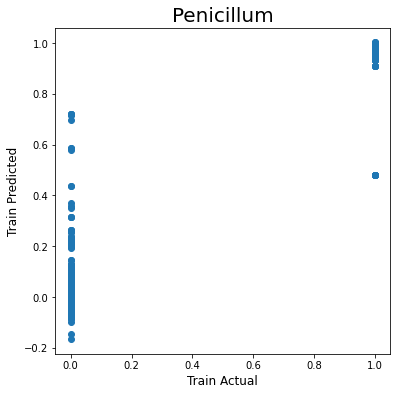

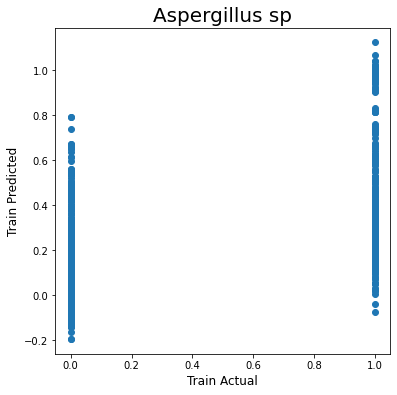

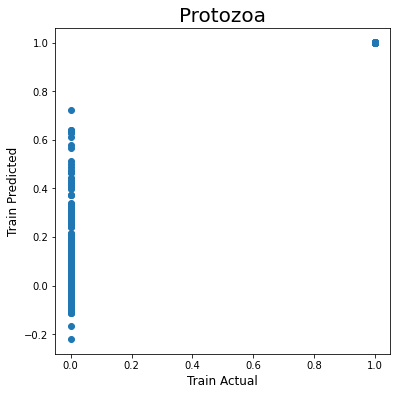

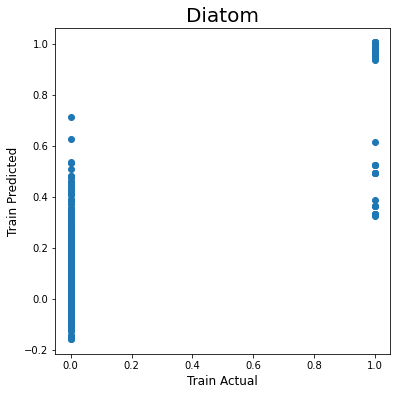

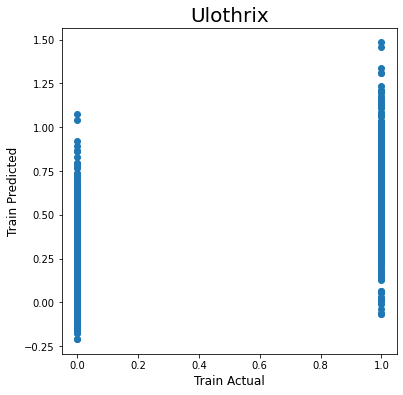

In [22]:
from sklearn.model_selection import KFold

for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('Train Actual',fontsize=12)
    ax.set_ylabel('Train Predicted',fontsize=12)
    ax.scatter(y,oof)


# Visualize Importance

In [23]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0609638
[1000]	valid_0's rmse: 0.0577356
[1500]	valid_0's rmse: 0.0564432
[2000]	valid_0's rmse: 0.0558882
[2500]	valid_0's rmse: 0.0556554
[3000]	valid_0's rmse: 0.0555032
[3500]	valid_0's rmse: 0.0554317
[4000]	valid_0's rmse: 0.0553888
fit fold=0  13.358[s]
Fold 0 RMSLE: 0.0554



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0524712
[1000]	valid_0's rmse: 0.0498459
[1500]	valid_0's rmse: 0.0483548
[2000]	valid_0's rmse: 0.0476713
[2500]	valid_0's rmse: 0.0473498
[3000]	valid_0's rmse: 0.0472262
[3500]	valid_0's rmse: 0.0471423
[4000]	valid_0's rmse: 0.0470865
[4500]	valid_0's rmse: 0.047041
[5000]	valid_0's rmse: 0.04701
[5500]	valid_0's rmse: 0.0469903
[6000]	valid_0's rmse: 0.0469738
[6500]	valid_0's rmse: 0.0469608
[7000]	valid_0's rmse: 0.0469489
fit fold=1  22.447[s]
Fold 1 RMSLE: 0.0469



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0710162
[1000]	valid_0's rmse: 0.0686147
[1500]	valid_0's rmse: 0.0671792
[2000]	valid_0's rmse: 0.0665596
[2500]	valid_0's rmse: 0.0662103
[3000]	valid_0's rmse: 0.0660431
[3500]	valid_0's rmse: 0.0659689
[4000]	valid_0's rmse: 0.0659208
[4500]	valid_0's rmse: 0.0658681
[5000]	valid_0's rmse: 0.0658383
[5500]	valid_0's rmse: 0.0658181
[6000]	valid_0's rmse: 0.0657977
[6500]	valid_0's rmse: 0.0657868
[7000]	valid_0's rmse: 0.065779
[7500]	valid_0's rmse: 0.0657698
[8000]	valid_0's rmse: 0.0657617
fit fold=2  25.297[s]
Fold 2 RMSLE: 0.0658



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0694295
[1000]	valid_0's rmse: 0.0664013
[1500]	valid_0's rmse: 0.0651915
[2000]	valid_0's rmse: 0.0646802
[2500]	valid_0's rmse: 0.0643374
[3000]	valid_0's rmse: 0.0642297
[3500]	valid_0's rmse: 0.064145
[4000]	valid_0's rmse: 0.0641055
[4500]	valid_0's rmse: 0.0640795
[5000]	valid_0's rmse: 0.0640545
[5500]	valid_0's rmse: 0.0640383
fit fold=3  17.162[s]
Fold 3 RMSLE: 0.0640



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0565566
[1000]	valid_0's rmse: 0.0536618
[1500]	valid_0's rmse: 0.0521568
[2000]	valid_0's rmse: 0.0516538
[2500]	valid_0's rmse: 0.0514009
[3000]	valid_0's rmse: 0.0513097
[3500]	valid_0's rmse: 0.0512623
[4000]	valid_0's rmse: 0.0512151
[4500]	valid_0's rmse: 0.0511908
[5000]	valid_0's rmse: 0.0511722
fit fold=4  16.405[s]
Fold 4 RMSLE: 0.0512

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0571


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0664567
[1000]	valid_0's rmse: 0.0410308
[1500]	valid_0's rmse: 0.0347083
[2000]	valid_0's rmse: 0.0325675
[2500]	valid_0's rmse: 0.031663
[3000]	valid_0's rmse: 0.0312316
[3500]	valid_0's rmse: 0.0310058
[4000]	valid_0's rmse: 0.0308614
[4500]	valid_0's rmse: 0.0307723
[5000]	valid_0's rmse: 0.0307152
[5500]	valid_0's rmse: 0.0306718
[6000]	valid_0's rmse: 0.0306379
[6500]	valid_0's rmse: 0.0306115
[7000]	valid_0's rmse: 0.0305964
fit fold=0  23.152[s]
Fold 0 RMSLE: 0.0306



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0722731
[1000]	valid_0's rmse: 0.0484233
[1500]	valid_0's rmse: 0.0431123
[2000]	valid_0's rmse: 0.0414875
[2500]	valid_0's rmse: 0.0408503
[3000]	valid_0's rmse: 0.0405691
[3500]	valid_0's rmse: 0.0404136
[4000]	valid_0's rmse: 0.040318
[4500]	valid_0's rmse: 0.0402493
[5000]	valid_0's rmse: 0.0401977
[5500]	valid_0's rmse: 0.0401694
[6000]	valid_0's rmse: 0.040142
[6500]	valid_0's rmse: 0.0401195
[7000]	valid_0's rmse: 0.040103
fit fold=1  22.086[s]
Fold 1 RMSLE: 0.0401



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.069912
[1000]	valid_0's rmse: 0.0437422
[1500]	valid_0's rmse: 0.0370191
[2000]	valid_0's rmse: 0.0347417
[2500]	valid_0's rmse: 0.0338833
[3000]	valid_0's rmse: 0.0334658
[3500]	valid_0's rmse: 0.033243
[4000]	valid_0's rmse: 0.0330989
[4500]	valid_0's rmse: 0.0330178
[5000]	valid_0's rmse: 0.0329506
[5500]	valid_0's rmse: 0.0329017
[6000]	valid_0's rmse: 0.0328647
[6500]	valid_0's rmse: 0.0328374
[7000]	valid_0's rmse: 0.0328177
[7500]	valid_0's rmse: 0.0328003
[8000]	valid_0's rmse: 0.0327842
[8500]	valid_0's rmse: 0.0327735
fit fold=2  26.134[s]
Fold 2 RMSLE: 0.0328



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0700618
[1000]	valid_0's rmse: 0.0421032
[1500]	valid_0's rmse: 0.0357858
[2000]	valid_0's rmse: 0.0338686
[2500]	valid_0's rmse: 0.0331073
[3000]	valid_0's rmse: 0.0327415
[3500]	valid_0's rmse: 0.0325731
[4000]	valid_0's rmse: 0.0324589
[4500]	valid_0's rmse: 0.0324002
[5000]	valid_0's rmse: 0.0323494
[5500]	valid_0's rmse: 0.0323167
[6000]	valid_0's rmse: 0.0322926
[6500]	valid_0's rmse: 0.0322759
[7000]	valid_0's rmse: 0.0322631
[7500]	valid_0's rmse: 0.0322495
[8000]	valid_0's rmse: 0.0322403
[8500]	valid_0's rmse: 0.032231
fit fold=3  26.138[s]
Fold 3 RMSLE: 0.0322



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0674812
[1000]	valid_0's rmse: 0.043863
[1500]	valid_0's rmse: 0.0380719
[2000]	valid_0's rmse: 0.0360291
[2500]	valid_0's rmse: 0.0352581
[3000]	valid_0's rmse: 0.0348969
[3500]	valid_0's rmse: 0.0347127
[4000]	valid_0's rmse: 0.034609
[4500]	valid_0's rmse: 0.0345418
[5000]	valid_0's rmse: 0.0344887
[5500]	valid_0's rmse: 0.0344519
[6000]	valid_0's rmse: 0.0344268
[6500]	valid_0's rmse: 0.0344012
[7000]	valid_0's rmse: 0.0343871
[7500]	valid_0's rmse: 0.0343752
[8000]	valid_0's rmse: 0.0343635
fit fold=4  25.137[s]
Fold 4 RMSLE: 0.0344

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0342


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.078441
[1000]	valid_0's rmse: 0.0651559
[1500]	valid_0's rmse: 0.0605106
[2000]	valid_0's rmse: 0.0587877
[2500]	valid_0's rmse: 0.0580563
[3000]	valid_0's rmse: 0.0577283
[3500]	valid_0's rmse: 0.0575698
[4000]	valid_0's rmse: 0.0574654
[4500]	valid_0's rmse: 0.0573961
[5000]	valid_0's rmse: 0.0573476
[5500]	valid_0's rmse: 0.0573138
[6000]	valid_0's rmse: 0.0572915
[6500]	valid_0's rmse: 0.0572764
[7000]	valid_0's rmse: 0.0572568
[7500]	valid_0's rmse: 0.0572429
[8000]	valid_0's rmse: 0.0572345
[8500]	valid_0's rmse: 0.0572281
[9000]	valid_0's rmse: 0.0572223
fit fold=0  26.568[s]
Fold 0 RMSLE: 0.0572



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0892113
[1000]	valid_0's rmse: 0.0764739
[1500]	valid_0's rmse: 0.0722161
[2000]	valid_0's rmse: 0.0704453
[2500]	valid_0's rmse: 0.0697081
[3000]	valid_0's rmse: 0.0694283
[3500]	valid_0's rmse: 0.0692483
[4000]	valid_0's rmse: 0.0691589
[4500]	valid_0's rmse: 0.0691014
[5000]	valid_0's rmse: 0.0690578
[5500]	valid_0's rmse: 0.0690292
[6000]	valid_0's rmse: 0.0690093
[6500]	valid_0's rmse: 0.0689952
[7000]	valid_0's rmse: 0.0689831
[7500]	valid_0's rmse: 0.0689722
fit fold=1  23.568[s]
Fold 1 RMSLE: 0.0690



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0909033
[1000]	valid_0's rmse: 0.0792985
[1500]	valid_0's rmse: 0.0753229
[2000]	valid_0's rmse: 0.073449
[2500]	valid_0's rmse: 0.0727673
[3000]	valid_0's rmse: 0.0724743
[3500]	valid_0's rmse: 0.072323
[4000]	valid_0's rmse: 0.0722239
[4500]	valid_0's rmse: 0.0721603
[5000]	valid_0's rmse: 0.0721271
fit fold=2  16.353[s]
Fold 2 RMSLE: 0.0721



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0887357
[1000]	valid_0's rmse: 0.07543
[1500]	valid_0's rmse: 0.0711117
[2000]	valid_0's rmse: 0.0694478
[2500]	valid_0's rmse: 0.0686434
[3000]	valid_0's rmse: 0.0683223
[3500]	valid_0's rmse: 0.0681717
[4000]	valid_0's rmse: 0.0680393
[4500]	valid_0's rmse: 0.06798
[5000]	valid_0's rmse: 0.0679328
[5500]	valid_0's rmse: 0.0679057
[6000]	valid_0's rmse: 0.0678813
[6500]	valid_0's rmse: 0.0678619
[7000]	valid_0's rmse: 0.0678511
fit fold=3  20.966[s]
Fold 3 RMSLE: 0.0678



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0843846
[1000]	valid_0's rmse: 0.0709032
[1500]	valid_0's rmse: 0.0654851
[2000]	valid_0's rmse: 0.0633132
[2500]	valid_0's rmse: 0.0623905
[3000]	valid_0's rmse: 0.0620002
[3500]	valid_0's rmse: 0.0617807
[4000]	valid_0's rmse: 0.0616699
[4500]	valid_0's rmse: 0.0616009
[5000]	valid_0's rmse: 0.0615517
[5500]	valid_0's rmse: 0.0615084
[6000]	valid_0's rmse: 0.0614844
[6500]	valid_0's rmse: 0.0614687
[7000]	valid_0's rmse: 0.061449
fit fold=4  22.529[s]
Fold 4 RMSLE: 0.0614

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0657


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0694965
[1000]	valid_0's rmse: 0.0508367
[1500]	valid_0's rmse: 0.0448114
[2000]	valid_0's rmse: 0.0427142
[2500]	valid_0's rmse: 0.0418712
[3000]	valid_0's rmse: 0.0414633
[3500]	valid_0's rmse: 0.0412425
[4000]	valid_0's rmse: 0.041108
[4500]	valid_0's rmse: 0.041021
[5000]	valid_0's rmse: 0.0409596
[5500]	valid_0's rmse: 0.0409109
[6000]	valid_0's rmse: 0.0408737
[6500]	valid_0's rmse: 0.0408479
[7000]	valid_0's rmse: 0.0408333
[7500]	valid_0's rmse: 0.0408213
[8000]	valid_0's rmse: 0.0408036
fit fold=0  23.704[s]
Fold 0 RMSLE: 0.0408



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.067779
[1000]	valid_0's rmse: 0.0470259
[1500]	valid_0's rmse: 0.0414438
[2000]	valid_0's rmse: 0.0398281
[2500]	valid_0's rmse: 0.0392399
[3000]	valid_0's rmse: 0.0389704
[3500]	valid_0's rmse: 0.0388226
[4000]	valid_0's rmse: 0.0387436
[4500]	valid_0's rmse: 0.0386808
[5000]	valid_0's rmse: 0.0386453
[5500]	valid_0's rmse: 0.0386239
[6000]	valid_0's rmse: 0.0386095
[6500]	valid_0's rmse: 0.0385937
[7000]	valid_0's rmse: 0.0385849
fit fold=1  22.663[s]
Fold 1 RMSLE: 0.0386



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0708661
[1000]	valid_0's rmse: 0.0493572
[1500]	valid_0's rmse: 0.0430022
[2000]	valid_0's rmse: 0.0408477
[2500]	valid_0's rmse: 0.0400469
[3000]	valid_0's rmse: 0.0396253
[3500]	valid_0's rmse: 0.0394394
[4000]	valid_0's rmse: 0.0393176
[4500]	valid_0's rmse: 0.039235
[5000]	valid_0's rmse: 0.0391901
[5500]	valid_0's rmse: 0.0391516
[6000]	valid_0's rmse: 0.0391189
[6500]	valid_0's rmse: 0.0390943
[7000]	valid_0's rmse: 0.0390796
[7500]	valid_0's rmse: 0.0390668
[8000]	valid_0's rmse: 0.0390584
fit fold=2  25.061[s]
Fold 2 RMSLE: 0.0391



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0714015
[1000]	valid_0's rmse: 0.0470625
[1500]	valid_0's rmse: 0.0393735
[2000]	valid_0's rmse: 0.0367816
[2500]	valid_0's rmse: 0.0357834
[3000]	valid_0's rmse: 0.0353498
[3500]	valid_0's rmse: 0.0351192
[4000]	valid_0's rmse: 0.0349784
[4500]	valid_0's rmse: 0.0348843
[5000]	valid_0's rmse: 0.0348206
[5500]	valid_0's rmse: 0.034769
[6000]	valid_0's rmse: 0.0347323
[6500]	valid_0's rmse: 0.0347032
[7000]	valid_0's rmse: 0.0346791
[7500]	valid_0's rmse: 0.0346598
[8000]	valid_0's rmse: 0.0346422
[8500]	valid_0's rmse: 0.0346301
[9000]	valid_0's rmse: 0.0346215
fit fold=3  27.311[s]
Fold 3 RMSLE: 0.0346



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0680488
[1000]	valid_0's rmse: 0.0492021
[1500]	valid_0's rmse: 0.0441403
[2000]	valid_0's rmse: 0.0426707
[2500]	valid_0's rmse: 0.0421442
[3000]	valid_0's rmse: 0.0419128
[3500]	valid_0's rmse: 0.0417692
[4000]	valid_0's rmse: 0.0417014
[4500]	valid_0's rmse: 0.0416517
[5000]	valid_0's rmse: 0.0416086
[5500]	valid_0's rmse: 0.0415814
[6000]	valid_0's rmse: 0.041559
[6500]	valid_0's rmse: 0.0415456
[7000]	valid_0's rmse: 0.0415321
[7500]	valid_0's rmse: 0.0415246
[8000]	valid_0's rmse: 0.0415193
fit fold=4  24.502[s]
Fold 4 RMSLE: 0.0415

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0390


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.00727441
[1000]	valid_0's rmse: 0.00491189
[1500]	valid_0's rmse: 0.00431054
[2000]	valid_0's rmse: 0.00406677
[2500]	valid_0's rmse: 0.00393055
fit fold=0  7.890[s]
Fold 0 RMSLE: 0.0039



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.00949856
[1000]	valid_0's rmse: 0.00645902
[1500]	valid_0's rmse: 0.00567964
[2000]	valid_0's rmse: 0.00541646
[2500]	valid_0's rmse: 0.00527764
fit fold=1  7.454[s]
Fold 1 RMSLE: 0.0052



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.00869679
[1000]	valid_0's rmse: 0.00621334
[1500]	valid_0's rmse: 0.0054886
[2000]	valid_0's rmse: 0.00515322
[2500]	valid_0's rmse: 0.00499192
fit fold=2  6.988[s]
Fold 2 RMSLE: 0.0050



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.00832648
[1000]	valid_0's rmse: 0.00651016
[1500]	valid_0's rmse: 0.00620834
[2000]	valid_0's rmse: 0.00610618
fit fold=3  5.723[s]
Fold 3 RMSLE: 0.0061



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0222615
[1000]	valid_0's rmse: 0.0215027
[1500]	valid_0's rmse: 0.0213946
[2000]	valid_0's rmse: 0.0213458
fit fold=4  7.940[s]
Fold 4 RMSLE: 0.0213

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0106


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.024652
[1000]	valid_0's rmse: 0.0193985
[1500]	valid_0's rmse: 0.0181
[2000]	valid_0's rmse: 0.017646
[2500]	valid_0's rmse: 0.0174282
[3000]	valid_0's rmse: 0.0173128
[3500]	valid_0's rmse: 0.0172369
[4000]	valid_0's rmse: 0.0171892
fit fold=0  12.453[s]
Fold 0 RMSLE: 0.0172



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0336976
[1000]	valid_0's rmse: 0.0270646
[1500]	valid_0's rmse: 0.0256803
[2000]	valid_0's rmse: 0.0252436
[2500]	valid_0's rmse: 0.0250793
[3000]	valid_0's rmse: 0.0249858
[3500]	valid_0's rmse: 0.0249252
[4000]	valid_0's rmse: 0.0248819
[4500]	valid_0's rmse: 0.0248519
[5000]	valid_0's rmse: 0.0248231
[5500]	valid_0's rmse: 0.0248068
[6000]	valid_0's rmse: 0.0247903
fit fold=1  18.602[s]
Fold 1 RMSLE: 0.0248



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.023141
[1000]	valid_0's rmse: 0.0169221
[1500]	valid_0's rmse: 0.0155944
[2000]	valid_0's rmse: 0.0151267
[2500]	valid_0's rmse: 0.0149402
[3000]	valid_0's rmse: 0.0148368
[3500]	valid_0's rmse: 0.0147682
[4000]	valid_0's rmse: 0.0147243
[4500]	valid_0's rmse: 0.0146946
fit fold=2  13.284[s]
Fold 2 RMSLE: 0.0147



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.025828
[1000]	valid_0's rmse: 0.0169639
[1500]	valid_0's rmse: 0.0146026
[2000]	valid_0's rmse: 0.0138666
[2500]	valid_0's rmse: 0.0135475
[3000]	valid_0's rmse: 0.0133783
[3500]	valid_0's rmse: 0.0132776
[4000]	valid_0's rmse: 0.0132063
[4500]	valid_0's rmse: 0.0131526
[5000]	valid_0's rmse: 0.0131127
fit fold=3  15.318[s]
Fold 3 RMSLE: 0.0131



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0368121
[1000]	valid_0's rmse: 0.0309464
[1500]	valid_0's rmse: 0.0298957
[2000]	valid_0's rmse: 0.0296378
[2500]	valid_0's rmse: 0.0295013
fit fold=4  8.981[s]
Fold 4 RMSLE: 0.0295

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0208


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.115062
[1000]	valid_0's rmse: 0.0829632
[1500]	valid_0's rmse: 0.069975
[2000]	valid_0's rmse: 0.0639953
[2500]	valid_0's rmse: 0.0615629
[3000]	valid_0's rmse: 0.0605253
[3500]	valid_0's rmse: 0.0599822
[4000]	valid_0's rmse: 0.0597014
[4500]	valid_0's rmse: 0.0595402
[5000]	valid_0's rmse: 0.0594322
[5500]	valid_0's rmse: 0.0593641
[6000]	valid_0's rmse: 0.0593117
[6500]	valid_0's rmse: 0.059271
[7000]	valid_0's rmse: 0.0592388
[7500]	valid_0's rmse: 0.0592152
[8000]	valid_0's rmse: 0.0591987
[8500]	valid_0's rmse: 0.0591864
[9000]	valid_0's rmse: 0.0591727
[9500]	valid_0's rmse: 0.0591619
[10000]	valid_0's rmse: 0.0591522
fit fold=0  30.471[s]
Fold 0 RMSLE: 0.0592



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.123525
[1000]	valid_0's rmse: 0.0957345
[1500]	valid_0's rmse: 0.0847926
[2000]	valid_0's rmse: 0.0800441
[2500]	valid_0's rmse: 0.0779486
[3000]	valid_0's rmse: 0.0769473
[3500]	valid_0's rmse: 0.0765493
[4000]	valid_0's rmse: 0.0763447
[4500]	valid_0's rmse: 0.0762075
[5000]	valid_0's rmse: 0.0761208
[5500]	valid_0's rmse: 0.0760686
[6000]	valid_0's rmse: 0.0760335
[6500]	valid_0's rmse: 0.0760079
[7000]	valid_0's rmse: 0.0759847
[7500]	valid_0's rmse: 0.0759711
[8000]	valid_0's rmse: 0.0759562
fit fold=1  25.963[s]
Fold 1 RMSLE: 0.0760



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.118069
[1000]	valid_0's rmse: 0.0876961
[1500]	valid_0's rmse: 0.0763868
[2000]	valid_0's rmse: 0.0714582
[2500]	valid_0's rmse: 0.0695216
[3000]	valid_0's rmse: 0.0686238
[3500]	valid_0's rmse: 0.0681893
[4000]	valid_0's rmse: 0.0679524
[4500]	valid_0's rmse: 0.0678141
[5000]	valid_0's rmse: 0.0677079
[5500]	valid_0's rmse: 0.067642
[6000]	valid_0's rmse: 0.0675896
[6500]	valid_0's rmse: 0.0675572
[7000]	valid_0's rmse: 0.0675249
[7500]	valid_0's rmse: 0.0675061
[8000]	valid_0's rmse: 0.0674924
[8500]	valid_0's rmse: 0.0674787
[9000]	valid_0's rmse: 0.0674646
[9500]	valid_0's rmse: 0.0674543
[10000]	valid_0's rmse: 0.0674495
fit fold=2  29.529[s]
Fold 2 RMSLE: 0.0674



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.120111
[1000]	valid_0's rmse: 0.0936576
[1500]	valid_0's rmse: 0.0836886
[2000]	valid_0's rmse: 0.0797811
[2500]	valid_0's rmse: 0.0779581
[3000]	valid_0's rmse: 0.0771704
[3500]	valid_0's rmse: 0.0767878
[4000]	valid_0's rmse: 0.0766091
[4500]	valid_0's rmse: 0.0764837
[5000]	valid_0's rmse: 0.076414
[5500]	valid_0's rmse: 0.0763666
[6000]	valid_0's rmse: 0.076326
[6500]	valid_0's rmse: 0.0763041
[7000]	valid_0's rmse: 0.0762827
fit fold=3  23.981[s]
Fold 3 RMSLE: 0.0763



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.120144
[1000]	valid_0's rmse: 0.0950745
[1500]	valid_0's rmse: 0.08672
[2000]	valid_0's rmse: 0.0831796
[2500]	valid_0's rmse: 0.0818102
[3000]	valid_0's rmse: 0.0811565
[3500]	valid_0's rmse: 0.0808751
[4000]	valid_0's rmse: 0.0807125
[4500]	valid_0's rmse: 0.0806154
[5000]	valid_0's rmse: 0.0805705
[5500]	valid_0's rmse: 0.0805308
[6000]	valid_0's rmse: 0.0805046
[6500]	valid_0's rmse: 0.0804856
[7000]	valid_0's rmse: 0.0804675
[7500]	valid_0's rmse: 0.0804553
fit fold=4  24.454[s]
Fold 4 RMSLE: 0.0805

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0723


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0392232
[1000]	valid_0's rmse: 0.028632
[1500]	valid_0's rmse: 0.0258074
[2000]	valid_0's rmse: 0.024821
[2500]	valid_0's rmse: 0.0244146
[3000]	valid_0's rmse: 0.0242021
[3500]	valid_0's rmse: 0.0240772
[4000]	valid_0's rmse: 0.0240019
[4500]	valid_0's rmse: 0.0239493
[5000]	valid_0's rmse: 0.0239103
[5500]	valid_0's rmse: 0.0238827
[6000]	valid_0's rmse: 0.0238593
fit fold=0  18.950[s]
Fold 0 RMSLE: 0.0239



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0402601
[1000]	valid_0's rmse: 0.0273334
[1500]	valid_0's rmse: 0.023498
[2000]	valid_0's rmse: 0.0220975
[2500]	valid_0's rmse: 0.0215364
[3000]	valid_0's rmse: 0.0212553
[3500]	valid_0's rmse: 0.0210888
[4000]	valid_0's rmse: 0.0209826
[4500]	valid_0's rmse: 0.0209208
[5000]	valid_0's rmse: 0.0208683
[5500]	valid_0's rmse: 0.0208362
[6000]	valid_0's rmse: 0.0208051
[6500]	valid_0's rmse: 0.0207834
[7000]	valid_0's rmse: 0.020764
[7500]	valid_0's rmse: 0.0207473
fit fold=1  23.380[s]
Fold 1 RMSLE: 0.0207



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.039771
[1000]	valid_0's rmse: 0.03048
[1500]	valid_0's rmse: 0.0280081
[2000]	valid_0's rmse: 0.0271038
[2500]	valid_0's rmse: 0.0267175
[3000]	valid_0's rmse: 0.026506
[3500]	valid_0's rmse: 0.026385
[4000]	valid_0's rmse: 0.0263033
[4500]	valid_0's rmse: 0.0262497
[5000]	valid_0's rmse: 0.0262088
[5500]	valid_0's rmse: 0.0261812
[6000]	valid_0's rmse: 0.0261598
[6500]	valid_0's rmse: 0.0261462
[7000]	valid_0's rmse: 0.0261342
[7500]	valid_0's rmse: 0.0261212
fit fold=2  22.726[s]
Fold 2 RMSLE: 0.0261



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0379319
[1000]	valid_0's rmse: 0.0268024
[1500]	valid_0's rmse: 0.0235927
[2000]	valid_0's rmse: 0.0224258
[2500]	valid_0's rmse: 0.0219283
[3000]	valid_0's rmse: 0.021668
[3500]	valid_0's rmse: 0.0215314
[4000]	valid_0's rmse: 0.0214439
[4500]	valid_0's rmse: 0.0213742
[5000]	valid_0's rmse: 0.0213245
[5500]	valid_0's rmse: 0.021293
[6000]	valid_0's rmse: 0.0212646
fit fold=3  18.432[s]
Fold 3 RMSLE: 0.0212



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0377597
[1000]	valid_0's rmse: 0.0273013
[1500]	valid_0's rmse: 0.0239856
[2000]	valid_0's rmse: 0.0227421
[2500]	valid_0's rmse: 0.0221621
[3000]	valid_0's rmse: 0.0218925
[3500]	valid_0's rmse: 0.0217333
[4000]	valid_0's rmse: 0.0216339
[4500]	valid_0's rmse: 0.0215541
[5000]	valid_0's rmse: 0.0215064
[5500]	valid_0's rmse: 0.0214694
[6000]	valid_0's rmse: 0.0214423
[6500]	valid_0's rmse: 0.0214177
[7000]	valid_0's rmse: 0.0214027
fit fold=4  21.696[s]
Fold 4 RMSLE: 0.0214

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0228


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.0573218
[1000]	valid_0's rmse: 0.0366572
[1500]	valid_0's rmse: 0.0309607
[2000]	valid_0's rmse: 0.0291515
[2500]	valid_0's rmse: 0.0284647
[3000]	valid_0's rmse: 0.0281415
[3500]	valid_0's rmse: 0.0279513
[4000]	valid_0's rmse: 0.0278478
[4500]	valid_0's rmse: 0.0277771
[5000]	valid_0's rmse: 0.027726
[5500]	valid_0's rmse: 0.0276954
[6000]	valid_0's rmse: 0.0276721
[6500]	valid_0's rmse: 0.027646
[7000]	valid_0's rmse: 0.027631
[7500]	valid_0's rmse: 0.0276179
fit fold=0  23.198[s]
Fold 0 RMSLE: 0.0276



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0527567
[1000]	valid_0's rmse: 0.0341603
[1500]	valid_0's rmse: 0.0284711
[2000]	valid_0's rmse: 0.0265924
[2500]	valid_0's rmse: 0.0258964
[3000]	valid_0's rmse: 0.0255866
[3500]	valid_0's rmse: 0.0254072
[4000]	valid_0's rmse: 0.0253041
[4500]	valid_0's rmse: 0.0252439
[5000]	valid_0's rmse: 0.025196
[5500]	valid_0's rmse: 0.025162
[6000]	valid_0's rmse: 0.0251341
[6500]	valid_0's rmse: 0.025114
[7000]	valid_0's rmse: 0.0250979
[7500]	valid_0's rmse: 0.0250858
fit fold=1  23.854[s]
Fold 1 RMSLE: 0.0251



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.064336
[1000]	valid_0's rmse: 0.0453972
[1500]	valid_0's rmse: 0.0402985
[2000]	valid_0's rmse: 0.0385172
[2500]	valid_0's rmse: 0.0377917
[3000]	valid_0's rmse: 0.0374745
[3500]	valid_0's rmse: 0.0372894
[4000]	valid_0's rmse: 0.0371633
[4500]	valid_0's rmse: 0.0370865
[5000]	valid_0's rmse: 0.03703
[5500]	valid_0's rmse: 0.0369923
[6000]	valid_0's rmse: 0.036962
[6500]	valid_0's rmse: 0.0369364
[7000]	valid_0's rmse: 0.0369138
[7500]	valid_0's rmse: 0.0368954
fit fold=2  24.390[s]
Fold 2 RMSLE: 0.0369



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0595758
[1000]	valid_0's rmse: 0.0415219
[1500]	valid_0's rmse: 0.0364658
[2000]	valid_0's rmse: 0.0350421
[2500]	valid_0's rmse: 0.0344624
[3000]	valid_0's rmse: 0.0341818
[3500]	valid_0's rmse: 0.0340599
[4000]	valid_0's rmse: 0.0339863
[4500]	valid_0's rmse: 0.0339335
[5000]	valid_0's rmse: 0.0339007
[5500]	valid_0's rmse: 0.0338738
fit fold=3  17.103[s]
Fold 3 RMSLE: 0.0339



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.0571309
[1000]	valid_0's rmse: 0.0387315
[1500]	valid_0's rmse: 0.0339092
[2000]	valid_0's rmse: 0.0323571
[2500]	valid_0's rmse: 0.031769
[3000]	valid_0's rmse: 0.0314724
[3500]	valid_0's rmse: 0.031308
[4000]	valid_0's rmse: 0.0312065
[4500]	valid_0's rmse: 0.0311408
[5000]	valid_0's rmse: 0.0310926
[5500]	valid_0's rmse: 0.0310599
[6000]	valid_0's rmse: 0.0310323
[6500]	valid_0's rmse: 0.0310112
[7000]	valid_0's rmse: 0.030994
[7500]	valid_0's rmse: 0.0309825
[8000]	valid_0's rmse: 0.0309703
fit fold=4  23.578[s]
Fold 4 RMSLE: 0.0310

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0312


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_ev

[500]	valid_0's rmse: 0.135657
[1000]	valid_0's rmse: 0.09626
[1500]	valid_0's rmse: 0.0817126
[2000]	valid_0's rmse: 0.0761184
[2500]	valid_0's rmse: 0.0737332
[3000]	valid_0's rmse: 0.0725827
[3500]	valid_0's rmse: 0.0720122
[4000]	valid_0's rmse: 0.0717067
[4500]	valid_0's rmse: 0.0715458
[5000]	valid_0's rmse: 0.0714371
[5500]	valid_0's rmse: 0.0713539
[6000]	valid_0's rmse: 0.0713115
[6500]	valid_0's rmse: 0.0712726
[7000]	valid_0's rmse: 0.0712451
[7500]	valid_0's rmse: 0.0712206
[8000]	valid_0's rmse: 0.0712008
[8500]	valid_0's rmse: 0.0711882
[9000]	valid_0's rmse: 0.0711753
[9500]	valid_0's rmse: 0.0711637
[10000]	valid_0's rmse: 0.0711545
fit fold=0  30.222[s]
Fold 0 RMSLE: 0.0712



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.133881
[1000]	valid_0's rmse: 0.0979525
[1500]	valid_0's rmse: 0.0866018
[2000]	valid_0's rmse: 0.0824913
[2500]	valid_0's rmse: 0.0807016
[3000]	valid_0's rmse: 0.0799241
[3500]	valid_0's rmse: 0.0795134
[4000]	valid_0's rmse: 0.0793133
[4500]	valid_0's rmse: 0.0791941
[5000]	valid_0's rmse: 0.0791163
[5500]	valid_0's rmse: 0.0790507
[6000]	valid_0's rmse: 0.0790084
[6500]	valid_0's rmse: 0.0789839
[7000]	valid_0's rmse: 0.0789623
[7500]	valid_0's rmse: 0.078947
[8000]	valid_0's rmse: 0.0789363
fit fold=1  25.200[s]
Fold 1 RMSLE: 0.0789



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.141576
[1000]	valid_0's rmse: 0.103342
[1500]	valid_0's rmse: 0.090688
[2000]	valid_0's rmse: 0.0858999
[2500]	valid_0's rmse: 0.0840091
[3000]	valid_0's rmse: 0.0832147
[3500]	valid_0's rmse: 0.0828001
[4000]	valid_0's rmse: 0.0826047
[4500]	valid_0's rmse: 0.0824746
[5000]	valid_0's rmse: 0.0823945
[5500]	valid_0's rmse: 0.0823302
[6000]	valid_0's rmse: 0.0822925
[6500]	valid_0's rmse: 0.082266
[7000]	valid_0's rmse: 0.0822499
[7500]	valid_0's rmse: 0.0822353
[8000]	valid_0's rmse: 0.0822207
fit fold=2  26.140[s]
Fold 2 RMSLE: 0.0822



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.138136
[1000]	valid_0's rmse: 0.0989811
[1500]	valid_0's rmse: 0.0853837
[2000]	valid_0's rmse: 0.0804422
[2500]	valid_0's rmse: 0.0783934
[3000]	valid_0's rmse: 0.0773961
[3500]	valid_0's rmse: 0.0769444
[4000]	valid_0's rmse: 0.0767117
[4500]	valid_0's rmse: 0.0765574
[5000]	valid_0's rmse: 0.076452
[5500]	valid_0's rmse: 0.0763819
[6000]	valid_0's rmse: 0.0763485
[6500]	valid_0's rmse: 0.0763154
[7000]	valid_0's rmse: 0.0762862
[7500]	valid_0's rmse: 0.0762655
[8000]	valid_0's rmse: 0.0762461
[8500]	valid_0's rmse: 0.0762282
[9000]	valid_0's rmse: 0.0762155
[9500]	valid_0's rmse: 0.0762066
[10000]	valid_0's rmse: 0.0761983
fit fold=3  30.448[s]
Fold 3 RMSLE: 0.0762



/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.14156
[1000]	valid_0's rmse: 0.105176
[1500]	valid_0's rmse: 0.0938139
[2000]	valid_0's rmse: 0.0892573
[2500]	valid_0's rmse: 0.0873742
[3000]	valid_0's rmse: 0.0865812
[3500]	valid_0's rmse: 0.0862172
[4000]	valid_0's rmse: 0.0859853
[4500]	valid_0's rmse: 0.085858
[5000]	valid_0's rmse: 0.085793
[5500]	valid_0's rmse: 0.0857536
[6000]	valid_0's rmse: 0.0857222
[6500]	valid_0's rmse: 0.0856984
[7000]	valid_0's rmse: 0.0856801
[7500]	valid_0's rmse: 0.085666
[8000]	valid_0's rmse: 0.085652
[8500]	valid_0's rmse: 0.085642
fit fold=4  27.648[s]
Fold 4 RMSLE: 0.0856

--------------------------------------------------
FINISHED | Whole RMSLE: 0.0790


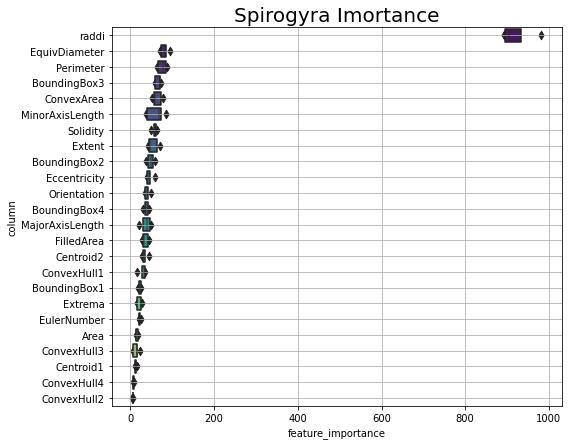

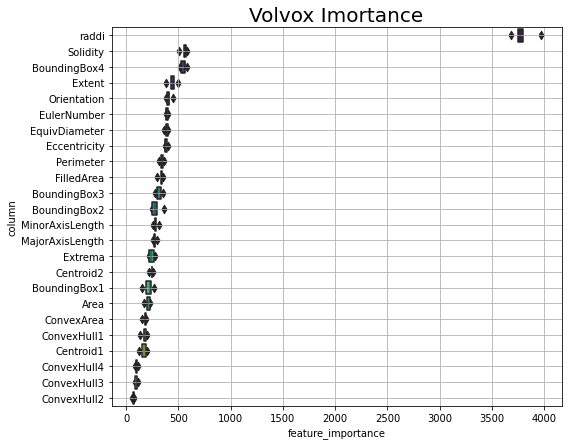

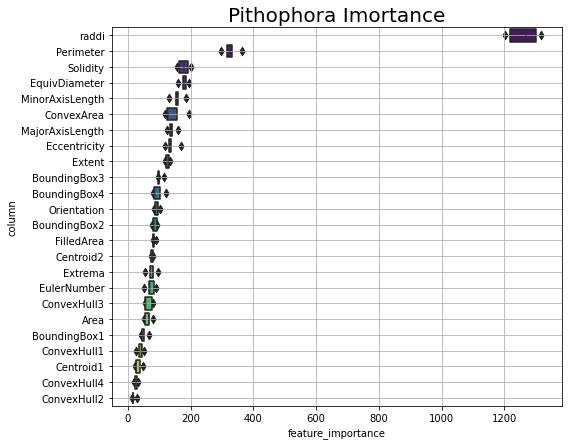

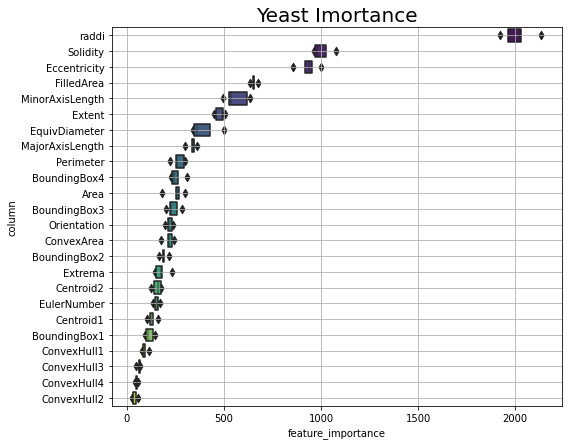

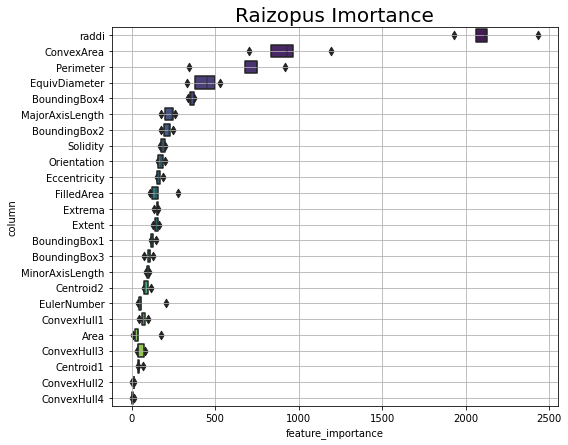

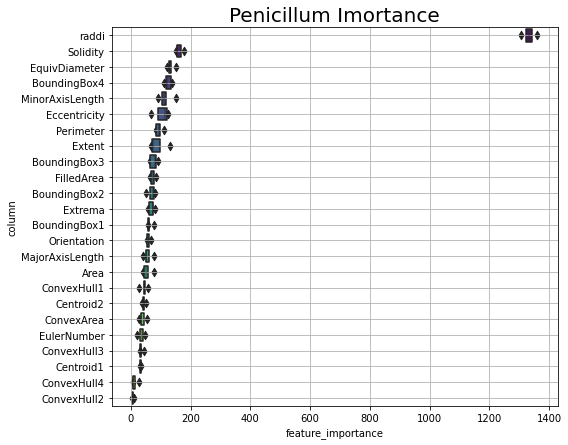

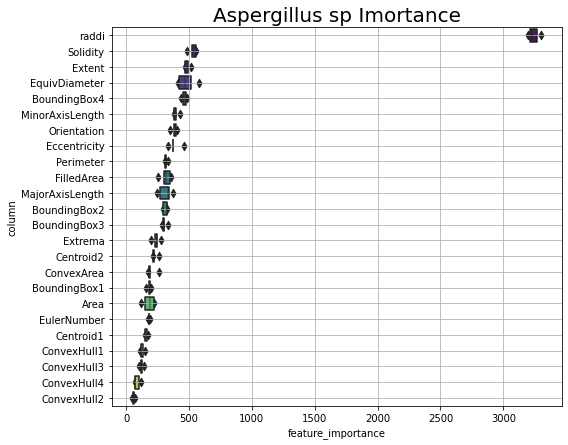

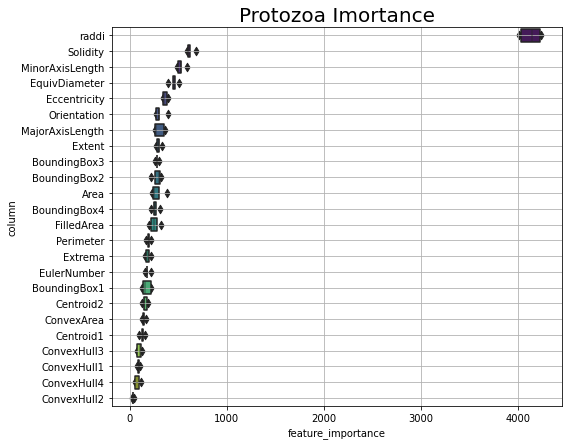

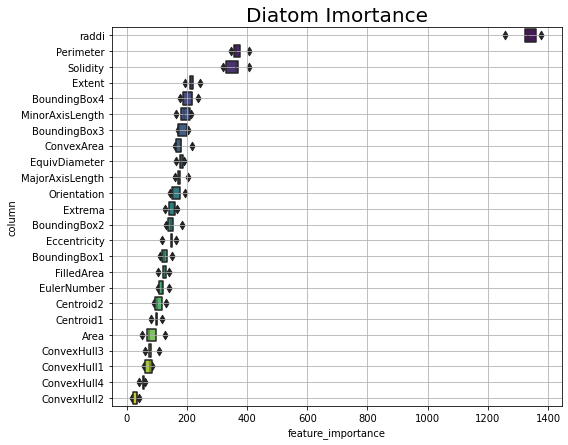

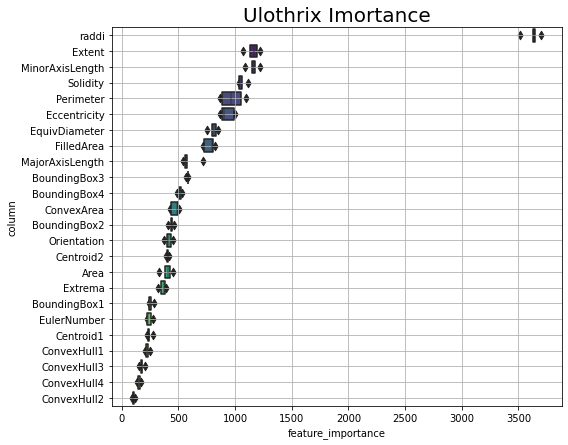

In [24]:
PREDS=[]
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)
    
    pred0 = np.array([model.predict(test_feat_df.values) for model in models])
    PREDS += [pred0[4]]

In [25]:
TName=['No','Yes']

In [26]:
for i in range(10):
    PREDi=PREDS[i]
    PREDi2=[]
    for item in PREDi:
        PREDi2+=[int(item)]

    ANSi=testY.iloc[:,i]
    ANSi2=[]
    for item in ANSi:
        ANSi2+=[item]
    
    print(MName[i])
    print(classification_report(np.array(ANSi2), np.array(PREDi2), target_names=TName, digits=4))

Spirogyra
              precision    recall  f1-score   support

          No     0.9861    1.0000    0.9930      7509
         Yes     1.0000    0.1520    0.2639       125

    accuracy                         0.9861      7634
   macro avg     0.9930    0.5760    0.6284      7634
weighted avg     0.9863    0.9861    0.9811      7634

Volvox
              precision    recall  f1-score   support

          No     0.8832    1.0000    0.9380      6510
         Yes     1.0000    0.2340    0.3792      1124

    accuracy                         0.8872      7634
   macro avg     0.9416    0.6170    0.6586      7634
weighted avg     0.9004    0.8872    0.8557      7634

Pithophora
              precision    recall  f1-score   support

          No     0.9595    1.0000    0.9793      7277
         Yes     1.0000    0.1401    0.2457       357

    accuracy                         0.9598      7634
   macro avg     0.9798    0.5700    0.6125      7634
weighted avg     0.9614    0.9598    0.9450   